# Attempt to convert TCGA data set for NIFTI format and make skull stripping with default library.

### The modules under test are 'dicom2nifti' and 'deepbrain'

In [120]:
import os
import cv2 
import random
import nibabel as nib
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import dicom2nifti

## Choose random patient

In [2]:
TCGA_path = Path('../Datasets/Sample_TCGA-GBM/TCGA-GBM/')
patient_folder = random.choice(os.listdir(TCGA_path))
patient_path = os.path.join(TCGA_path, patient_folder)
patient_path

'../Datasets/Sample_TCGA-GBM/TCGA-GBM/TCGA-02-0070'

In [16]:
for last_subdir in os.walk(patient_path):
    pass

files_path = Path(last_subdir[0])
files_path

PosixPath('../Datasets/Sample_TCGA-GBM/TCGA-GBM/TCGA-02-0070/07-10-2000-MRI BRAIN WWO CONTRAST-48290/12.000000-FSPGR 3D-67548')

In [17]:
nifti_folder = os.path.join(files_path, 'NIFTI')
os.makedirs(nifti_folder, exist_ok=True)

In [18]:
nifti_file = os.path.join(nifti_folder, f'{patient_folder}')

## Test dicom to nifti conversion

In [19]:
dicom2nifti.dicom_series_to_nifti(files_path, nifti_file, reorient_nifti=True)

{'NII_FILE': '../Datasets/Sample_TCGA-GBM/TCGA-GBM/TCGA-02-0070/07-10-2000-MRI BRAIN WWO CONTRAST-48290/12.000000-FSPGR 3D-67548/NIFTI/TCGA-02-0070',
 'NII': <nibabel.nifti1.Nifti1Image at 0x7f6fe7790278>,
 'MAX_SLICE_INCREMENT': 1.4999983739837397}

In [20]:
nib_object = nib.load(nifti_file + '.nii')
patient_array = nib_object.get_fdata()

patient_array.shape

(512, 512, 124)

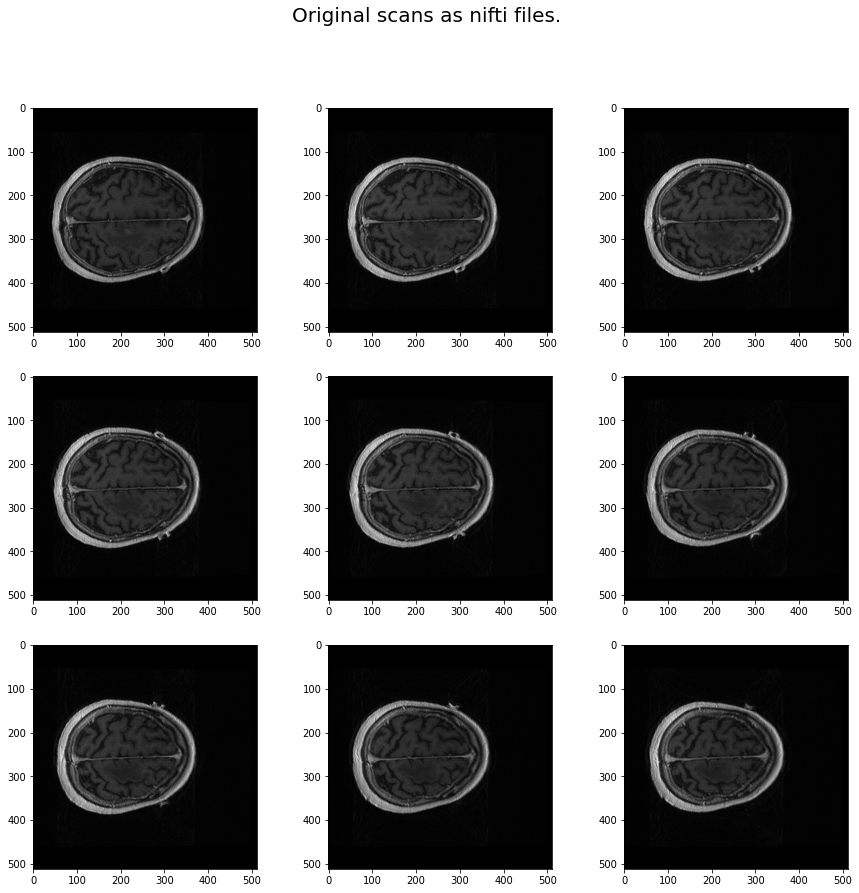

In [99]:
first_slice_idx = 90

fig = plt.figure(figsize=(15,14))
fig.suptitle('Original scans as nifti files.', fontsize=20)

for i in range(9):
    sub_fig = fig.add_subplot(3,3,i+1)
    sub_fig.imshow(patient_array[:,:,first_slice_idx + i], cmap='gray')

plt.show()

In [22]:
print(nib_object.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 124   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.488281   0.488281   1.4999983  1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 126.527
qoffset_y       : -77.31659
qoffset_z  

## Test skull stripping

### The extraction was made from command line: "deepbrain-extractor -i PATIENT.nii -o ."
### The command was exacuted inside NIFTI directory.

In [28]:
os.listdir(nifti_folder)

['brain.nii', 'brain_mask.nii', 'TCGA-02-0070.nii']

In [29]:
brain_file = os.path.join(nifti_folder, 'brain.nii')
brainmask_file = os.path.join(nifti_folder, 'brain_mask.nii')

In [30]:
brain_object = nib.load(brain_file)
brain_array = brain_object.get_fdata()

brainmask_object = nib.load(brainmask_file)
brainmask_array = brainmask_object.get_fdata()

brain_array.shape, brainmask_array.shape

((512, 512, 124), (512, 512, 124))

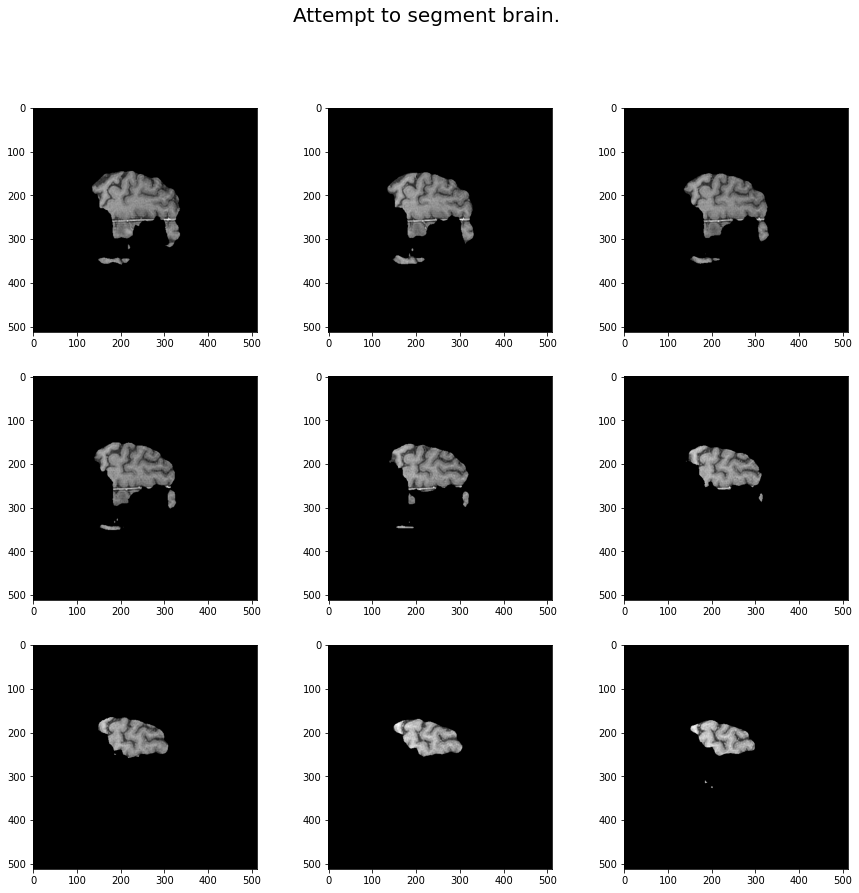

In [98]:
first_slice_idx = 90

fig = plt.figure(figsize=(15,14))
fig.suptitle('Attempt to segment brain.', fontsize=20)

for i in range(9):
    sub_fig = fig.add_subplot(3,3,i+1)
    sub_fig.imshow(brain_array[:,:,first_slice_idx + i], cmap='gray')

plt.show()

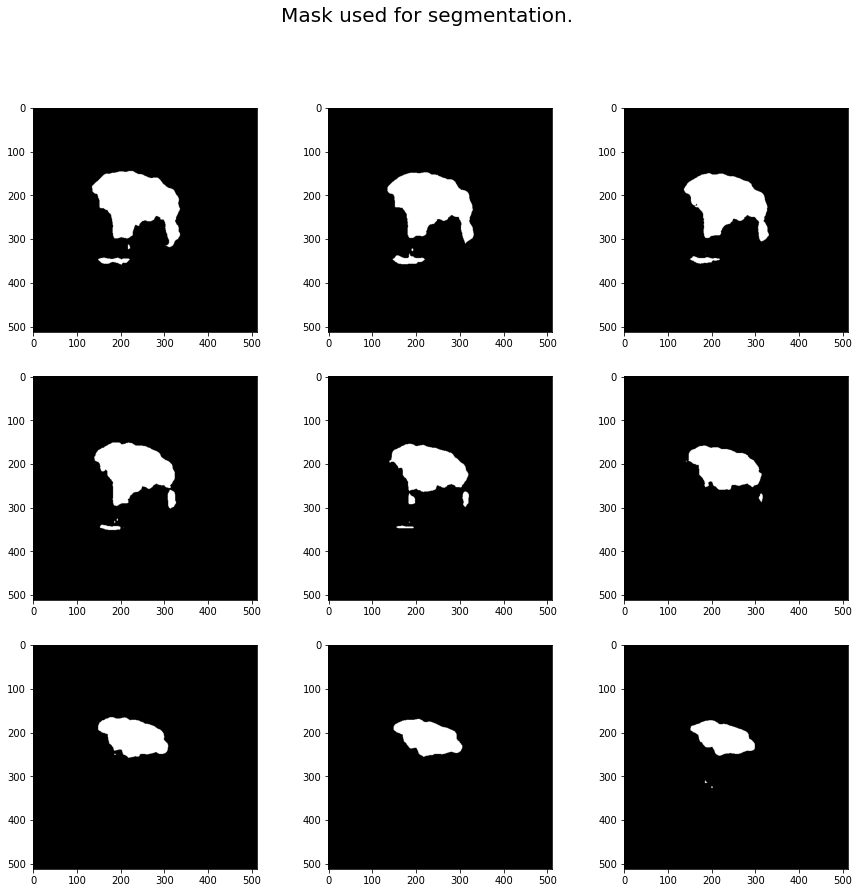

In [100]:
first_slice_idx = 90

fig = plt.figure(figsize=(15,14))
fig.suptitle('Mask used for segmentation.', fontsize=20)

for i in range(9):
    sub_fig = fig.add_subplot(3,3,i+1)
    sub_fig.imshow(brainmask_array[:,:,first_slice_idx + i], cmap='gray')

plt.show()

### There are many reasons for poor performance in the cancer dataset. These are datasets with very advanced tumors, which probably were not included in the model's training.

### In addition, the images have higher quality, such as 512x512x124. The resize process can compromise performance.

## Comparison with the same patient extracted from BraTS dataset.

#### At first, recall where the constructed nifti file is saved and where we are in the system.

In [39]:
nifti_folder, os.getcwd()

('../Datasets/Sample_TCGA-GBM/TCGA-GBM/TCGA-02-0070/07-10-2000-MRI BRAIN WWO CONTRAST-48290/12.000000-FSPGR 3D-67548/NIFTI',
 '/home/matheus/Documents/ProjetoBRICS/BrainMRI')

### Lets's find the same patient in BraTS Dataset with the help of .CSV name mapping file.

In [42]:
brats_training_path = Path('../Datasets/Brats19Files/MICCAI_BraTS_2019_Data_Training')
name_map_path = os.path.join(brats_training_path, 'name_mapping.csv')

name_df = pd.read_csv(name_map_path)
name_df.head()

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID
0,HGG,Brats17_CBICA_AAB_1,Brats18_CBICA_AAB_1,NaN,BraTS19_CBICA_AAB_1
1,HGG,Brats17_CBICA_AAG_1,Brats18_CBICA_AAG_1,NaN,BraTS19_CBICA_AAG_1
2,HGG,Brats17_CBICA_AAL_1,Brats18_CBICA_AAL_1,NaN,BraTS19_CBICA_AAL_1
3,HGG,Brats17_CBICA_AAP_1,Brats18_CBICA_AAP_1,NaN,BraTS19_CBICA_AAP_1
4,HGG,Brats17_CBICA_ABB_1,Brats18_CBICA_ABB_1,NaN,BraTS19_CBICA_ABB_1


In [43]:
patient_name = patient_folder
patient_name

'TCGA-02-0070'

In [45]:
patient_name_mapping = name_df.loc[name_df['TCGA_TCIA_subject_ID'] == patient_name]
patient_name_mapping

,Grade,BraTS_2017_subject_ID,BraTS_2018_subject_ID,TCGA_TCIA_subject_ID,BraTS_2019_subject_ID
171,HGG,Brats17_TCIA_131_1,Brats18_TCIA01_131_1,TCGA-02-0070,BraTS19_TCIA01_131_1


In [59]:
grade = patient_name_mapping['Grade'].item()
pat_brats_folder = patient_name_mapping['BraTS_2019_subject_ID'].item()

grade, pat_brats_folder

('HGG', 'BraTS19_TCIA01_131_1')

In [65]:
pat_brats_path = os.path.join(brats_training_path, grade, pat_brats_folder)

os.listdir(pat_brats_path)

['BraTS19_TCIA01_131_1_seg.nii.gz',
 'BraTS19_TCIA01_131_1_t1ce.nii.gz',
 'BraTS19_TCIA01_131_1_flair.nii.gz',
 'BraTS19_TCIA01_131_1_t1.nii.gz',
 'BraTS19_TCIA01_131_1_t2.nii.gz']

#### Since contrast makes tumor more evident, let's compare with 'tice' file.

In [70]:
pat_brats_file = pat_brats_folder + '_t1ce.nii.gz'
pat_brats_file = os.path.join(pat_brats_path, pat_brats_file)

nib_obj_brats = nib.load(pat_brats_file)
pat_brats_array = nib_obj_brats.get_fdata()

### Compare shapes between two versions.

In [71]:
pat_brats_array.shape, patient_array.shape

((240, 240, 155), (512, 512, 124))

### Since BraTS dataset was normalized for a specific shape, the incompatibility was expected.
### However, let's try to find visual matches between cancers.

#### In the original scan, the tumor can be well visualized in following slices:

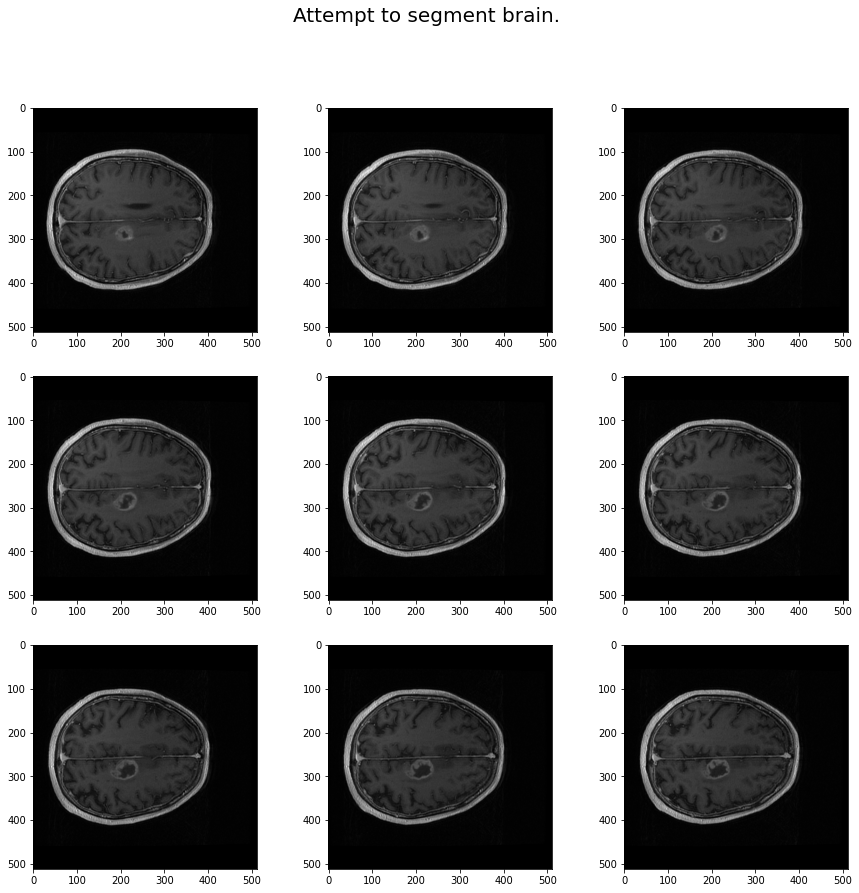

In [101]:
first_slice_idx = 75

fig = plt.figure(figsize=(15,14))
fig.suptitle('Attempt to segment brain.', fontsize=20)

for i in range(9):
    sub_fig = fig.add_subplot(3,3,i+1)
    sub_fig.imshow(patient_array[:,:,first_slice_idx + i], cmap='gray')

plt.show()

### Since original scan has 124 slices and its brats version has 155, let's check with dataset was upsampled or padded with zeros in depth.

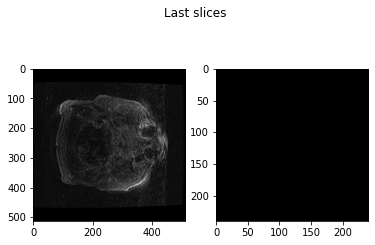

In [82]:
fig = plt.figure()
fig.suptitle('Last slices')

sub_fig_1 = fig.add_subplot(1,2,1)
sub_fig_1.imshow(patient_array[:,:,patient_array.shape[-1]-1], cmap='gray')

sub_fig_2 = fig.add_subplot(1,2,2)
sub_fig_2.imshow(pat_brats_array[:,:,pat_brats_array.shape[-1]-1], cmap='gray')

plt.show()

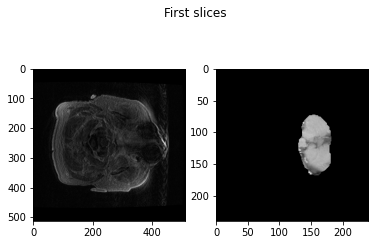

In [90]:
fig = plt.figure()
fig.suptitle('First slices')

sub_fig_1 = fig.add_subplot(1,2,1)
sub_fig_1.imshow(patient_array[:,:,0], cmap='gray')

sub_fig_2 = fig.add_subplot(1,2,2)
sub_fig_2.imshow(pat_brats_array[:,:,0], cmap='gray')

plt.show()

### With the help of the segmented tumor, we will look for correspondence.

In [105]:
pat_brats_segfile = pat_brats_folder + '_seg.nii.gz'
pat_brats_segfile = os.path.join(pat_brats_path, pat_brats_segfile)

nib_obj_brats_seg = nib.load(pat_brats_segfile)
pat_brats_seg_array = nib_obj_brats_seg.get_fdata()

### Plot some slices for all scans.

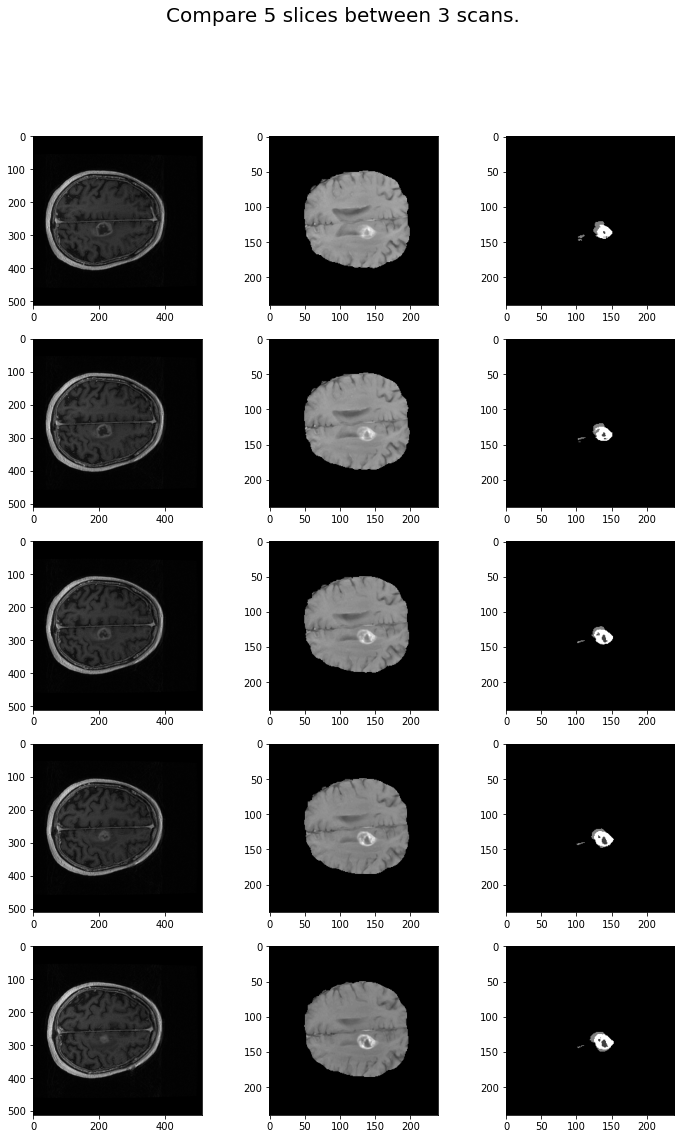

In [118]:
orig_first_idx = brats_first_idx = 85

fig = plt.figure(figsize=(12, 18))
fig.suptitle('Compare 5 slices between 3 scans.', fontsize=20)

for i in range(5):
    orig_subfig = fig.add_subplot(5, 3, (1 + (3*i)))
    orig_subfig.imshow(patient_array[:,:,orig_first_idx + i], cmap='gray')

    brain_subfig = fig.add_subplot(5, 3, (2 + (3*i)))
    brain_subfig.imshow(pat_brats_array[:,:,brats_first_idx + i], cmap='gray')

    seg_subfig = fig.add_subplot(5, 3, (3 + (3*i)))
    seg_subfig.imshow(pat_brats_seg_array[:,:,brats_first_idx + i], cmap='gray')

plt.show()

### It can be seen that for the slices shown above, the 3D image was in indeed upsampled for the BraTS dataset.

### Let's check the resolution of the original scan with the spatial dimensions of the Brats dataset.

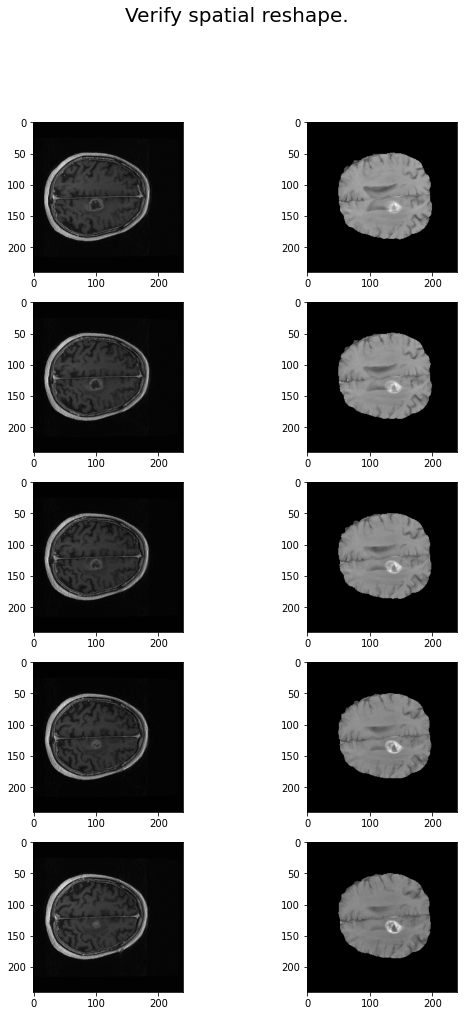

In [127]:
orig_first_idx = brats_first_idx = 85

fig = plt.figure(figsize=(9, 16))
fig.suptitle('Verify spatial reshape.', fontsize=20)

for i in range(5):
    orig_subfig = fig.add_subplot(5, 2, (1 + (2*i)))
    resampled_slice = cv2.resize(patient_array[:,:,orig_first_idx + i], dsize=pat_brats_array.shape[:2], interpolation=cv2.INTER_CUBIC)
    orig_subfig.imshow(resampled_slice, cmap='gray')

    brain_subfig = fig.add_subplot(5, 2, (2 + (2*i)))
    brain_subfig.imshow(pat_brats_array[:,:,brats_first_idx + i], cmap='gray')

plt.show()

### The result was satisfatory. Let's check depth axes.

#### Besides the 155 slices, BraTS dataset finishes in slice 130.

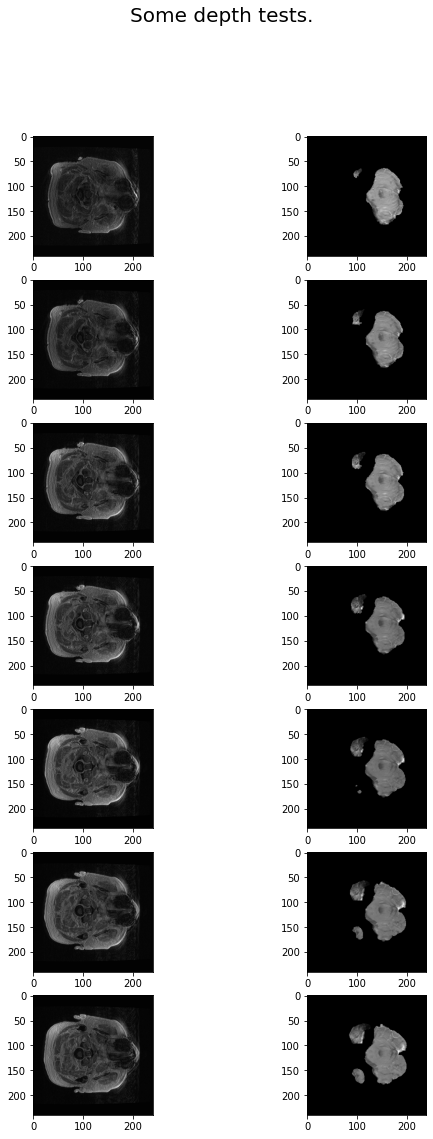

In [136]:
orig_first_idx = 0
brats_first_idx = 20

fig = plt.figure(figsize=(9, 18))
fig.suptitle('Some depth tests.', fontsize=20)

for i in range(7):
    orig_subfig = fig.add_subplot(7, 2, (1 + (2*i)))
    resampled_slice = cv2.resize(patient_array[:,:,orig_first_idx + i], dsize=pat_brats_array.shape[:2], interpolation=cv2.INTER_CUBIC)
    orig_subfig.imshow(resampled_slice, cmap='gray')

    brain_subfig = fig.add_subplot(7, 2, (2 + (2*i)))
    brain_subfig.imshow(pat_brats_array[:,:,brats_first_idx + i], cmap='gray')

plt.show()